# Neural Network Algorithms

## THEORY
__2.__ 3x3/2 max pooling applied to an input feature map of size 3 x (2n + 1) generates an output
feature map of size 1 x n. What is the minimum number of comparisons required to generate
the output feature map? Draw a picture showing your pattern of comparisons (hand drawing is
ok).

__SOLUTION__

Minimal number of comparisons should be 8*n. 8 comparisons for each shift of the 3x3 pooling block.
![alt text](https://raw.githubusercontent.com/harrisonjansma/2019_Notes/master/DL/Courses/CS6301/img/20200203_133000.jpg)

__3.__
3x3/2 max pooling applied to an input feature map of size (2m + 1) x (2n + 1) generates an
output feature map of size m x n. What is the minimum number of comparisons required to
generate the output feature map? Draw a picture showing your pattern of comparisons (hand
drawing is ok).

__SOLUTION__

Minimal number of comparisons should be 8*n*m. 8 comparisons for each shift of the 3x3 pooling block.
![alt text](https://raw.githubusercontent.com/harrisonjansma/2019_Notes/master/DL/Courses/CS6301/img/20200203_133000.jpg)

## Code
[source](https://github.com/arthurredfern/UT-Dallas-CS-6301-CNNs/blob/master/Code/xNNs_Code_020_CIFAR.py)

In [1]:
################################################################################
#
# xNNs_Code_020_CIFAR.py
#
# DESCRIPTION
#
#    TensorFlow image classification using CIFAR
#
# INSTRUCTIONS
#
#    1. Go to Google Colaboratory: https://colab.research.google.com/notebooks/welcome.ipynb
#    2. File - New Python 3 notebook
#    3. Cut and paste this file into the cell (feel free to divide into multiple cells)
#    4. Runtime - Change runtime type - Hardware accelerator - GPU
#    5. Runtime - Run all
#
# NOTES
#
#    1. This configuration achieves 90.4% accuracy in 30 epochs with each epoch
#       taking ~ 24s on Google Colab.  Accuracy can be improved via
#       - Improved training data augmentation
#       - Improved network design
#       - Improved network training
#
#    2. Examples (currently commented out) are included for the following
#       - Computing the dataset mean and std dev
#       - Restarting training after a crash from the last saved checkpoint
#       - Saving and loading the model in Keras H5 format
#       - Saving and loading the model in TensorFlow SavedModel format
#       - Getting a list of all feature maps
#       - Creating an encoder only model
#
################################################################################

################################################################################
#
# IMPORT
#
################################################################################


# install tensorflow 2 and tensorflow datasets on a personal machine
# !pip install tensorflow-gpu
# !pip install tensorflow-datasets

# tenorflow
import tensorflow as     tf
from   tensorflow import keras

# tensorflow datasets
import tensorflow_datasets as tfds

# additional libraries
import math
import numpy             as np
import matplotlib.pyplot as plt
%matplotlib inline

# version check
print(tf.__version__)

2.1.0


In [3]:
################################################################################
#
# PARAMETERS
#
################################################################################

# data
DATA_NUM_CLASSES        = 10
DATA_CHANNELS           = 3
DATA_ROWS               = 32
DATA_COLS               = 32
DATA_CROP_ROWS          = 28
DATA_CROP_COLS          = 28
DATA_MEAN               = np.array([[[125.30691805, 122.95039414, 113.86538318]]]) # CIFAR10
DATA_STD_DEV            = np.array([[[ 62.99321928,  62.08870764,  66.70489964]]]) # CIFAR10

# model
MODEL_LEVEL_0_REPEATS   = 3
MODEL_LEVEL_1_REPEATS   = 3
MODEL_LEVEL_2_REPEATS   = 3

# training
TRAINING_BATCH_SIZE      = 32
TRAINING_SHUFFLE_BUFFER  = 5000
TRAINING_LR_MAX          = 0.001
# TRAINING_LR_SCALE        = 0.1
# TRAINING_LR_EPOCHS       = 2
TRAINING_LR_INIT_SCALE   = 0.01
TRAINING_LR_INIT_EPOCHS  = 5
TRAINING_LR_FINAL_SCALE  = 0.01
TRAINING_LR_FINAL_EPOCHS = 25

# training (derived)
TRAINING_NUM_EPOCHS = TRAINING_LR_INIT_EPOCHS + TRAINING_LR_FINAL_EPOCHS
TRAINING_LR_INIT    = TRAINING_LR_MAX*TRAINING_LR_INIT_SCALE
TRAINING_LR_FINAL   = TRAINING_LR_MAX*TRAINING_LR_FINAL_SCALE

# saving
SAVE_MODEL_PATH = './save/model/'
#!mkdir "$SAVE_MODEL_PATH"

In [4]:
################################################################################
#
# DATA
#
################################################################################

# pre processing for training data
def pre_processing_train(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]
  
    # image is cast to float32, normalized, augmented and random cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    #H MAGE CHANGES HERE( NO RANDOM ROTATION)
    image = tf.image.random_crop(image, size=[DATA_CROP_ROWS, DATA_CROP_COLS, 3])
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

# pre processing for testing data
def pre_processing_test(example):

    # extract image and label from example
    image = example["image"]
    label = example["label"]

    # image is cast to float32, normalized, augmented and center cropped
    # label is cast to int32
    image = tf.math.divide(tf.math.subtract(tf.dtypes.cast(image, tf.float32), DATA_MEAN), DATA_STD_DEV)
    image = tf.image.crop_to_bounding_box(image, (DATA_ROWS - DATA_CROP_ROWS) // 2, (DATA_COLS - DATA_CROP_COLS) // 2, DATA_CROP_ROWS, DATA_CROP_COLS)
    label = tf.dtypes.cast(label, tf.int32)
    
    # return image and label
    return image, label

# download data and split into training and testing datasets
# download data and split into training and testing datasets
dataset_train, info = tfds.load("cifar10", split=tfds.Split.TRAIN, with_info=True)
dataset_test,  info = tfds.load("cifar10", split=tfds.Split.TEST,  with_info=True)

# d
# debug - datasets
#print(train_images) # <_OptionsDataset shapes: {image: (32, 32, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
# print(dataset_test)  # <_OptionsDataset shapes: {image: (32, 32, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [5]:
# transform training dataset
dataset_train = dataset_train.map(pre_processing_train, num_parallel_calls=4)
dataset_train = dataset_train.shuffle(buffer_size=TRAINING_SHUFFLE_BUFFER)
dataset_train = dataset_train.batch(TRAINING_BATCH_SIZE)
dataset_train = dataset_train.prefetch(buffer_size=1)

In [6]:
# transform testing dataset
dataset_test = dataset_test.map(pre_processing_test, num_parallel_calls=4)
dataset_test = dataset_test.batch(TRAINING_BATCH_SIZE)
dataset_test = dataset_test.prefetch(buffer_size=1)

# debug - datasets after transformation
# print(dataset_train) # <PrefetchDataset shapes: ((None, 28, 28, 3), (None,)), types: (tf.float32, tf.int32)>
# print(dataset_test)  # <PrefetchDataset shapes: ((None, 28, 28, 3), (None,)), types: (tf.float32, tf.int32)>

In [25]:
################################################################################
#
# MODEL
#
################################################################################

# create and compile model
def create_model(level_0_repeats, level_1_repeats, level_2_repeats):

    # encoder - input
    model_input = keras.Input(shape=(DATA_CROP_ROWS, DATA_CROP_COLS, DATA_CHANNELS), name='input_image')
    x = model_input
    
    # encoder - level 0
    for n0 in range(level_0_repeats):
        # x = keras.layers.Conv2D(32, 3, strides=1, padding='same', activation='relu', use_bias=True)(x)
        x = keras.layers.Conv2D(32, 3, strides=1, padding='same', activation=None, use_bias=False)(x)
        x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)(x)
        x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

    # encoder - level 1
    for n1 in range(level_1_repeats):
        # x = keras.layers.Conv2D(64, 3, strides=1, padding='same', activation='relu', use_bias=True)(x)
        x = keras.layers.Conv2D(64, 3, strides=1, padding='same', activation=None, use_bias=False)(x)
        x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)(x)
        x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
        
    # encoder - level 2
    for n2 in range(level_2_repeats):
        # x = keras.layers.Conv2D(128, 3, strides=1, padding='same', activation='relu', use_bias=True)(x)
        x = keras.layers.Conv2D(128, 3, strides=1, padding='same', activation=None, use_bias=False)(x)
        x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True)(x)
        x = keras.layers.ReLU()(x)

    # encoder - output
    encoder_output = x

    # decoder
    y = keras.layers.GlobalAveragePooling2D()(encoder_output)
    decoder_output = keras.layers.Dense(DATA_NUM_CLASSES, activation='softmax')(y)
    
    # forward path
    model = keras.Model(inputs=model_input, outputs=decoder_output, name='cifar_model')

    # loss, backward path (implicit) and weight update
    model.compile(optimizer=tf.keras.optimizers.Adam(TRAINING_LR_MAX), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # return model
    return model

# create and compile model
model = create_model(MODEL_LEVEL_0_REPEATS, MODEL_LEVEL_1_REPEATS, MODEL_LEVEL_2_REPEATS)

# model description and figure
model.summary()
keras.utils.plot_model(model, 'cifar_model.png', show_shapes=True)

# debug - model metrics (values returned from model.evaluate)
# print(model.metrics_names) # ['loss', 'accuracy']

Model: "cifar_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 28, 28, 3)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 32)        864       
_________________________________________________________________
batch_normalization_9 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
re_lu_9 (ReLU)               (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        9216      
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
re_lu_10 (ReLU)              (None, 28, 28, 32)        

Epoch 1/30
   1563/Unknown - 22s 14ms/step - loss: 1.8013 - accuracy: 0.3426
Epoch 00001: val_loss improved from inf to 1.50206, saving model to ./save/model/model_1.h5
1563/1563 [==============================] - 24s 15ms/step - loss: 1.8013 - accuracy: 0.3426 - val_loss: 1.5021 - val_accuracy: 0.4593
Epoch 2/30
1557/1563 [============================>.] - ETA: 0s - loss: 1.2067 - accuracy: 0.5687
Epoch 00002: val_loss improved from 1.50206 to 1.15905, saving model to ./save/model/model_2.h5
1563/1563 [==============================] - 17s 11ms/step - loss: 1.2061 - accuracy: 0.5689 - val_loss: 1.1591 - val_accuracy: 0.5947
Epoch 3/30
1560/1563 [============================>.] - ETA: 0s - loss: 0.9056 - accuracy: 0.6811
Epoch 00003: val_loss improved from 1.15905 to 0.96262, saving model to ./save/model/model_3.h5
1563/1563 [==============================] - 18s 11ms/step - loss: 0.9051 - accuracy: 0.6812 - val_loss: 0.9626 - val_accuracy: 0.6711
Epoch 4/30
1558/1563 [================

Epoch 28/30
1560/1563 [============================>.] - ETA: 0s - loss: 0.0485 - accuracy: 0.9841
Epoch 00028: val_loss did not improve from 0.44507
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0485 - accuracy: 0.9841 - val_loss: 0.4550 - val_accuracy: 0.8821
Epoch 29/30
1558/1563 [============================>.] - ETA: 0s - loss: 0.0394 - accuracy: 0.9873
Epoch 00029: val_loss did not improve from 0.44507
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0394 - accuracy: 0.9873 - val_loss: 0.4472 - val_accuracy: 0.8862
Epoch 30/30
1561/1563 [============================>.] - ETA: 0s - loss: 0.0366 - accuracy: 0.9892
Epoch 00030: val_loss improved from 0.44507 to 0.43979, saving model to ./save/model/model_30.h5
1563/1563 [==============================] - 18s 11ms/step - loss: 0.0366 - accuracy: 0.9892 - val_loss: 0.4398 - val_accuracy: 0.8893


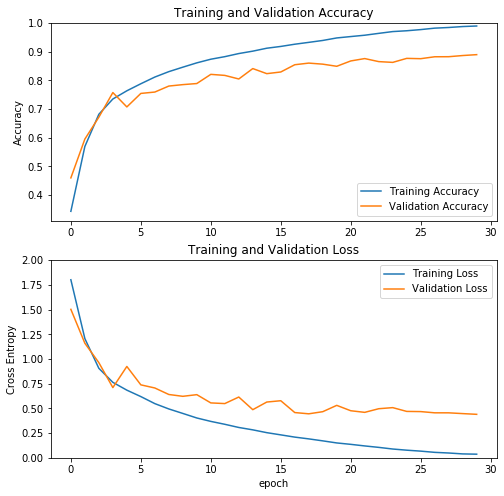

In [26]:
################################################################################
#
# TRAIN AND VALIDATE
#
################################################################################

# learning rate schedule
def lr_schedule(epoch):

    # staircase
    # lr = TRAINING_LR_MAX*math.pow(TRAINING_LR_SCALE, math.floor(epoch/TRAINING_LR_EPOCHS))

    # linear warmup followed by cosine decay
    if epoch < TRAINING_LR_INIT_EPOCHS:
        lr = (TRAINING_LR_MAX - TRAINING_LR_INIT)*(float(epoch)/TRAINING_LR_INIT_EPOCHS) + TRAINING_LR_INIT
    else:
        lr = (TRAINING_LR_MAX - TRAINING_LR_FINAL)*max(0.0, math.cos(((float(epoch) - TRAINING_LR_INIT_EPOCHS)/(TRAINING_LR_FINAL_EPOCHS - 1.0))*(math.pi/2.0))) + TRAINING_LR_FINAL

    # debug - learning rate display
    # print(epoch)
    # print(lr)

    return lr

# plot training accuracy and loss curves
def plot_training_curves(history):

    # training and validation data accuracy
    acc     = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # training and validation data loss
    loss     = history.history['loss']
    val_loss = history.history['val_loss']

    # plot accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    # plot loss
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0, 2.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

# callbacks (learning rate schedule, model checkpointing during training)
callbacks = [keras.callbacks.LearningRateScheduler(lr_schedule),
             keras.callbacks.ModelCheckpoint(filepath=SAVE_MODEL_PATH+'model_{epoch}.h5', save_best_only=True, monitor='val_loss', verbose=1)]

# training
initial_epoch_num = 0
history = model.fit(x=dataset_train, epochs=TRAINING_NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=dataset_test, initial_epoch=initial_epoch_num)

# example of restarting training after a crash from the last saved checkpoint
# model             = create_model(MODEL_LEVEL_0_REPEATS, MODEL_LEVEL_1_REPEATS, MODEL_LEVEL_2_REPEATS)
# model.load_weights(SAVE_MODEL_PATH+'model_X.h5') # replace X with the last saved checkpoint number
# initial_epoch_num = X                            # replace X with the last saved checkpoint number
# history           = model.fit(x=dataset_train, epochs=TRAINING_NUM_EPOCHS, verbose=1, callbacks=callbacks, validation_data=dataset_test, initial_epoch=initial_epoch_num)

# plot accuracy and loss curves
plot_training_curves(history)

    313/Unknown - 2s 7ms/step - loss: 0.4398 - accuracy: 0.8893Test loss:      0.43979009178975903
Test accuracy:  0.8893
Predicted label: 2 and actual label: 7


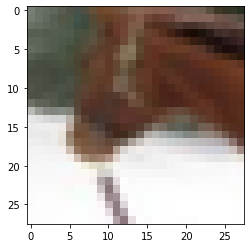

Predicted label: 0 and actual label: 0


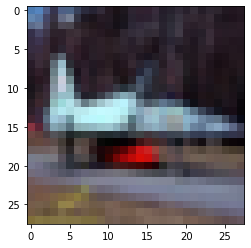

Predicted label: 6 and actual label: 6


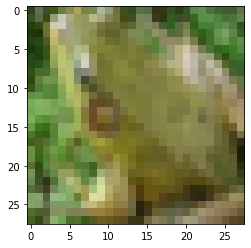

Predicted label: 9 and actual label: 9


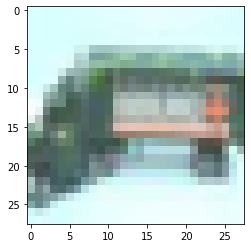

Predicted label: 5 and actual label: 5


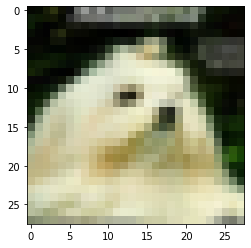

Predicted label: 1 and actual label: 1


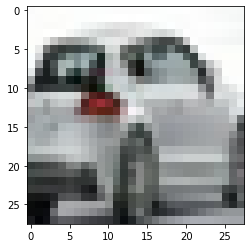

Predicted label: 7 and actual label: 7


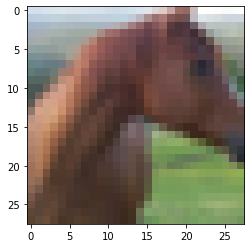

Predicted label: 0 and actual label: 0


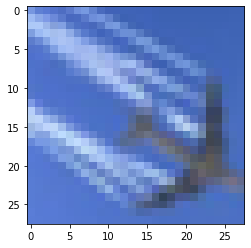

Predicted label: 5 and actual label: 3


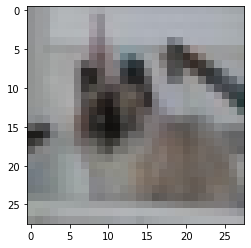

Predicted label: 2 and actual label: 2


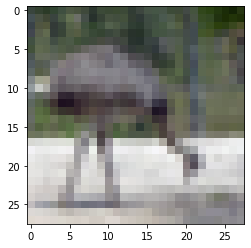

Predicted label: 7 and actual label: 7


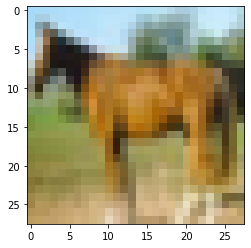

Predicted label: 2 and actual label: 2


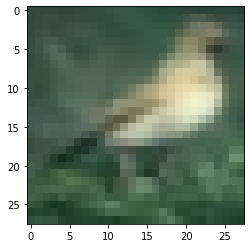

Predicted label: 7 and actual label: 7


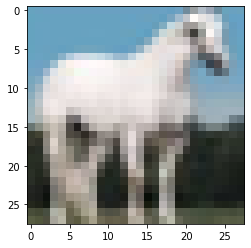

Predicted label: 9 and actual label: 9


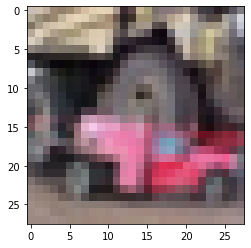

Predicted label: 5 and actual label: 6


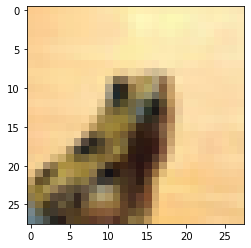

Predicted label: 8 and actual label: 8


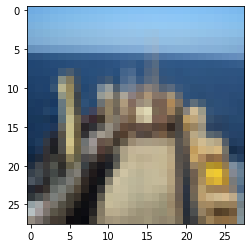

Predicted label: 8 and actual label: 8


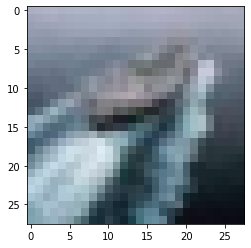

Predicted label: 8 and actual label: 8


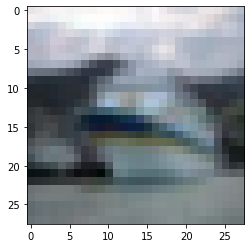

Predicted label: 7 and actual label: 7


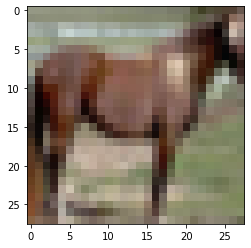

Predicted label: 9 and actual label: 9


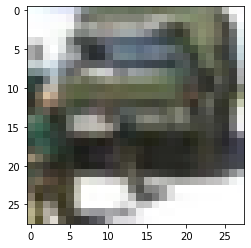

Predicted label: 4 and actual label: 4


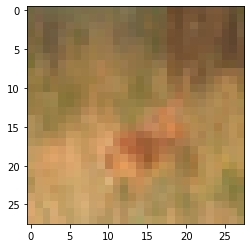

Predicted label: 2 and actual label: 2


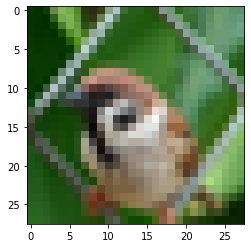

Predicted label: 3 and actual label: 3


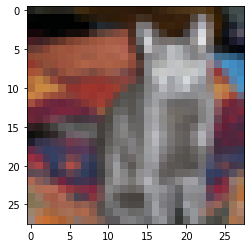

Predicted label: 5 and actual label: 5


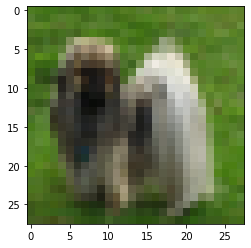

Predicted label: 0 and actual label: 0


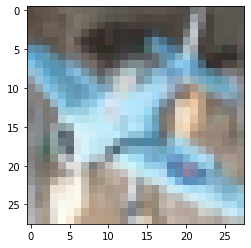

Predicted label: 8 and actual label: 0


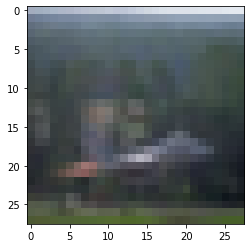

Predicted label: 2 and actual label: 2


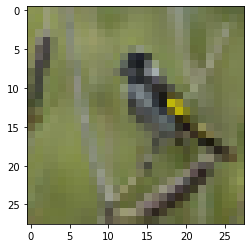

Predicted label: 8 and actual label: 8


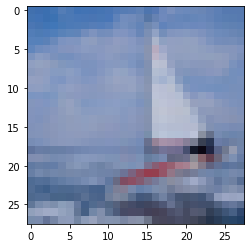

Predicted label: 1 and actual label: 1


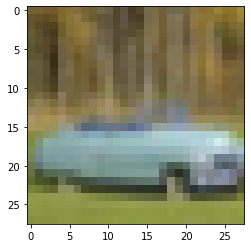

Predicted label: 8 and actual label: 8


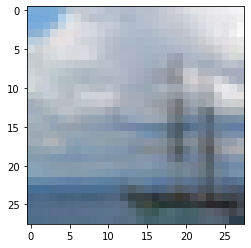

Predicted label: 2 and actual label: 2


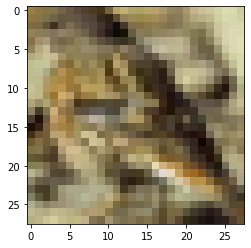

Predicted label: 0 and actual label: 0


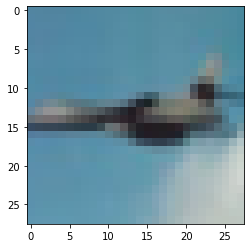

In [27]:
################################################################################
#
# TEST
#
################################################################################

# test
test_loss, test_accuracy = model.evaluate(x=dataset_test)
print('Test loss:     ', test_loss)
print('Test accuracy: ', test_accuracy)

# example of saving and loading the model in Keras H5 format
# this saves both the model and the weights
# model.save('./save/model/model.h5')
# new_model       = keras.models.load_model('./save/model/model.h5')
# predictions     = model.predict(x=dataset_test)
# new_predictions = new_model.predict(x=dataset_test)
# np.testing.assert_allclose(predictions, new_predictions, atol=1e-6)

# example of saving and loading the model in TensorFlow SavedModel format
# this saves both the model and the weights
# keras.experimental.export_saved_model(model, './save/model/')
# new_model       = keras.experimental.load_from_saved_model('./save/model/')
# predictions     = model.predict(x=dataset_test)
# new_predictions = new_model.predict(x=dataset_test)
# np.testing.assert_allclose(predictions, new_predictions, atol=1e-6)

# example of getting a list of all feature maps
# feature_map_list = [layer.output for layer in model.layers]
# print(feature_map_list)

# example of creating a model encoder
# replace X with the layer number of the encoder output
# model_encoder    = keras.Model(inputs=model.input, outputs=model.layers[X].output)
# model_encoder.summary()

################################################################################
#
# DISPLAY
#
################################################################################

# extract a batch from the testing dataset
# then extract images and labels for this batch
dataset_display                = dataset_test.take(1)
it                             = iter(dataset_display)
display_images, display_labels = next(it)

# predict pmf and labels for this dataset
predict_labels_pmf = model.predict(x=dataset_display)
predict_labels     = np.argmax(predict_labels_pmf, axis=1)

# for display normalize images to [0, 1]
display_images = ((display_images*DATA_STD_DEV.reshape((1, 1, 1, 3))) + DATA_MEAN.reshape((1, 1, 1, 3)))/255.0;

# cycle through the images in the batch
for image_index in range(predict_labels.size):
        
    # display the predicted label, actual label and image
    print('Predicted label: {0:1d} and actual label: {1:1d}'.format(predict_labels[image_index], display_labels[image_index]))
    plt.imshow(display_images[image_index, :, :, :])
    plt.show()